<a href="https://colab.research.google.com/github/ypeng22/DLFinal/blob/main/image_cnn_lstm_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [1]:
data_dir = "/content/gdrive/MyDrive/rgb_video_data"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([126, 3, 240, 180])


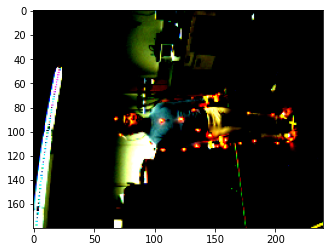

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pickle
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import resnet101
import random
import torch.nn.functional as F
import time
subjects = ['S01', 'S02', 'S03', 'S04', 'S05','S06', 'S07', 'S08', 'S09', 'S10', 'S11', 'S12']
actions = ['A01', 'A02', 'A03', 'A04', 'A05','A06', 'A07', 'A08', 'A09', 'A10', 'A11']
reps = ['R01', 'R02', 'R03', 'R04', 'R05']

class BerkeleyMHAD(Dataset):

    def __init__(self, vid_names, root_dir, classes, transform=None):
        self.vid_names = vid_names # list of file names for videos (ex. S01_A01_R01)
        self.root_dir = root_dir # directory where videos are stored
        self.transform = transform
        self.classes = classes
        
    def __len__(self):
        return len(self.vid_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        path = os.path.join(self.root_dir, self.vid_names[idx])
        x = np.load(path)['x']
        
        data = []
        if self.transform:
            for i in range(x.shape[0]):
                data.append(self.transform(x[i]))
        
        vid_tensor = torch.stack(data)
        label = self.classes.index(np.load(path)['y']) 
        sample = {'x': vid_tensor, 'y': label}

        return sample

class cnn_block(nn.Module):
    def __init__(self):
        super(cnn_block, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 100, 3)
        self.pool1 = nn.MaxPool2d(3)

        self._initialize_weights()

    def forward(self, x):
        batch = x.shape[0]
        x1 = self.pool1(F.relu(self.conv1(x)))
        x1 = self.pool1(F.relu(self.conv2(x1)))
        x1 = self.pool1(F.relu(self.conv3(x1)))
        x1 = F.relu(self.conv4(x1))
        x1 = x1.reshape(batch, -1).unsqueeze(0)

        return x1

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                nn.init.constant_(m.bias, 0) 

class lstm_block(nn.Module):
    def __init__(self, classes):
        super(lstm_block, self).__init__()
        self.n_hidden = 128
        self.grucell_1 = torch.nn.GRUCell(input_size = 1500,
                                            hidden_size = self.n_hidden)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, classes)

        self._initialize_weights()

    def forward(self, x):
        h1 = torch.zeros(1, self.n_hidden).to(dev)
        output = []
        h1s = []
        
        x = x.permute(1,0,2)
        h1.requires_grad=True
        h1.retain_grad()
        for i in range(x.size()[0]):
            h1 = self.grucell_1(x[i], h1)
            h1.retain_grad()
            output.append(h1)

        lstm_out = torch.stack(output, dim=0)

        lstm_out.retain_grad()
        out = lstm_out[-1,:,:]
        out = F.relu(self.fc2(out.squeeze()))
        out = self.fc3(out)

        return out, lstm_out

    def get_states(self, x):
        h1 = torch.zeros(1, self.n_hidden).to(dev)
        h1s = []
        x = x.permute(1,0,2)
        for i in range(x.size()[0]):
            h1s.append(h1)
            h1 = self.grucell_1(x[i], h1)
            
        hidden_states = torch.stack(h1s, dim=0)
        hidden_states.retain_grad()

        return hidden_states

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out',
                                        nonlinearity='relu')
                nn.init.constant_(m.bias, 0)  


class cnn_lstm(nn.Module):
    def __init__(self, classes):
        super(cnn_lstm, self).__init__()
        self.cnn_block = cnn_block()
        self.lstm_block = lstm_block(classes)

    def forward(self, x):
        x1 = self.cnn_block(x)
        out, lstm_out = self.lstm_block(x1)

        return out, lstm_out


def check(i):
    #insert more i.find terms for each action
    return i.find('A01') != -1 or i.find('A02') != -1 or i.find('A05') != -1 or i.find('A07') != -1 
vid_names = [i for i in next(os.walk(data_dir))[2] if check(i)]

#vid_names = os.listdir(data_dir)
train_vid_names = [i for i in vid_names if i.find('S09') == -1 and i.find('S10') == -1 and i.find('S11') == -1 and i.find('S12') == -1]
valid_vid_names = [i for i in vid_names if i.find('S09') != -1 ]
test_vid_names = [i for i in vid_names if i.find('S10') != -1 or i.find('S11') != -1 or i.find('S12') != -1]

#data shape is (num_pics, height, width, channel)
Normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
train_dataset = BerkeleyMHAD(train_vid_names, data_dir, classes = [0, 1, 4, 6], transform=transforms.Compose([transforms.ToTensor(), Normalize]))
valid_dataset = BerkeleyMHAD(valid_vid_names, data_dir, classes = [0, 1, 4, 6], transform=transforms.Compose([transforms.ToTensor(), Normalize]))
test_dataset = BerkeleyMHAD(test_vid_names, data_dir, classes = [0, 1, 4, 6], transform=transforms.Compose([transforms.ToTensor(), Normalize]))
plt.imshow(np.transpose(train_dataset[0]['x'][0]))
print(train_dataset[0]['x'].shape)

batch_size = 1

dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#change 2 to number of classes

In [3]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [ ]:
#no need to train
'''model = cnn_lstm(4).to(dev)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/lstm_checkpoints/gru_best_state_dict_unrolled_1_layer.pt'))

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
epoch = 10
#train
shuffled = np.arange(len(train_dataset))

train_losses = []
val_losses = []
tcorrect = 0
ttotal = 0

for t in range(epoch):
    train_loss = 0
    valid_loss = 0
    tguess = []
    tanswers = []
    tcorrect = 0
    ttotal = 0
    random.shuffle(shuffled)

    model.train()

    for i in range(len(train_dataset)):
        optimizer.zero_grad()

        data = train_dataset[shuffled[i]]
        inpt = data['x'].to(dev)
        label = torch.tensor(data['y']).unsqueeze(0).to(dev)
        output = model(inpt)[0].unsqueeze(0)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()  
        train_loss += loss.item()
        
        if torch.argmax(output.squeeze()) == label:
            tcorrect += 1
        ttotal += 1
    
    torch.cuda.empty_cache()   
    model.eval()
    for i in range(len(valid_dataset)):
        data = valid_dataset[i]
        inpt = data['x'].to(dev)
        label = torch.tensor(data['y']).unsqueeze(0).to(dev)
        output = model(inpt)[0].unsqueeze(0)
        loss = criterion(output, label)
        valid_loss += loss.item()
    print("epoch:", valid_loss / len(valid_dataset), train_loss / len(train_dataset))
    train_losses.append(train_loss / len(train_dataset))
    val_losses.append(valid_loss / len(valid_dataset))
    if valid_loss / len(valid_dataset) <= min(val_losses):
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/lstm_checkpoints/gru_best_state_dict_unrolled_1_layer.pt')'''
    


In [4]:
model = cnn_lstm(4).to(dev)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/gru_best_state_dict_unrolled_1_layer.pt'))

correct = 0
total = 0
model.eval()
#with torch.no_grad():
for i in range(len(test_dataset)):
    data = test_dataset[i]
    inpt = data['x'].to(dev)
    label = torch.tensor(data['y']).to(dev)
    output2 = model(inpt)
    if torch.argmax(output2[0].squeeze()) == label:
        correct += 1
    total += 1

print("test accuracy = " + str(correct / total))


test accuracy = 0.9215686274509803


In [5]:
from torch.autograd import Variable
class GradientAttack():
        
        """
        
        """
        
        def __init__(self, loss, epsilon):
            """
            
            """
            self.loss = loss
            self.epsilon = epsilon

        def forward(self, x, y, model, num_iter=1, alpha=0.01):
            """
            
            """
            y = torch.Tensor([y]).cuda()
            model.train()
            x = model.cnn_block(x)
            x_adv = x.clone().detach()

            torch.manual_seed(0)
            x_adv = x_adv + torch.empty_like(x_adv).uniform_(-self.epsilon, self.epsilon)
            #x_adv = torch.clamp(x_adv, min=0, max=1).detach()
            if num_iter == 1:
              alpha = self.epsilon
            for iteration in range(num_iter):
                x_adv = x_adv.cuda()
                x_adv = Variable(x_adv, requires_grad=True)
                # Step 1: Calculate the Loss and then calculate the
                # gradient of the Loss w.r.t the image
                out = model.lstm_block(x_adv)
                loss_adv = self.loss(out[0].unsqueeze(0), y.long())
                loss_adv.backward(retain_graph=True) 

                with torch.no_grad():
                    # Step 2: Add the gradient (or its sign for each pixel),
                    # multiplied by a small step size, to the original image                   
                    # You might need to clamp the modified image to 
                    # make sure the values of each pixel are between [0,1]    
                    #if num_iter > 1:                                                           
                    x_temp = x_adv + torch.sign(x_adv.grad) * alpha
                    #x_temp = x_adv + x_adv.grad * alpha
                        
                    # Clamp the attack to be within such that the maximum difference is epsilon
                    delta = torch.clamp(x_temp - x, -self.epsilon, self.epsilon)
                    x_adv = x + delta
 
                    #else:
                        #x_adv = x + torch.sign(x_adv.grad) * self.epsilon
                    
            #x_adv = torch.clamp(x_adv, 0, 1)
            return x_adv

In [6]:
class HAttack():
        
        """
        
        """
        
        def __init__(self, loss, epsilon):
            """
            
            """
            self.loss = loss
            self.epsilon = epsilon


        def to_the_moon(self, x, y, model, num_iter=1, pmp_iter = 1, alpha=0.01):
            """
            forward with saved iterations
            """
            y = torch.Tensor([y]).cuda()
            model.train()
            torch.manual_seed(0)
            delta = torch.empty_like(x_adv).uniform_(-self.epsilon, self.epsilon)
            delta.requires_grad = True        
            for iteration in range(num_iter):
                x_adv = x_adv.cuda()
                
                out = model.lstm_block(x_adv + delta)
                loss_adv = self.loss(out[0].unsqueeze(0), y.long())
                loss_adv.backward(retain_graph=True) 

                hidden_states = out[1] 
                p = hidden_states.grad[:,0,:].clone().detach()

                hidden_states = model.lstm_block.get_states(x_adv + delta)

                for i in range(pmp_iter): 
                    f = model.lstm_block.grucell_1((x_adv + delta).squeeze(), hidden_states.squeeze()).unsqueeze(1)
                    objective = torch.sum(p * f.squeeze(), axis=1).to(dev)
                    grad = torch.autograd.grad(objective, delta, torch.ones(x_adv.shape[1]).to(dev), retain_graph=True, create_graph=False)[0]

                    delta = delta + alpha * torch.sign(grad)
                    delta = torch.clamp(delta, -self.epsilon, self.epsilon)

            #x_adv = torch.clamp(x_adv, 0, 1)
            x_adv = x + delta
            return x_adv

        def forward(self, x, y, model, num_iter=1, pmp_iter = 1, alpha=0.01, cnn=False):
            """
            
            """       
            
            y = torch.Tensor([y]).cuda()
            model.train()
            if cnn:
              x = model.cnn_block(x)
            x_adv = x.clone().detach()

            torch.manual_seed(0)
            delta = torch.empty_like(x_adv).uniform_(-self.epsilon, self.epsilon)
            delta.requires_grad = True

            for iteration in range(num_iter):
                x_adv = x_adv.cuda()
                
                out = model.lstm_block(x_adv + delta)
                loss_adv = self.loss(out[0].unsqueeze(0), y.long())
                loss_adv.backward(retain_graph=True) 

                hidden_states = out[1] 
                p = hidden_states.grad[:,0,:].clone().detach()

                hidden_states = model.lstm_block.get_states(x_adv + delta)

                for i in range(pmp_iter): 
                    f = model.lstm_block.grucell_1((x_adv + delta).squeeze(), hidden_states.squeeze()).unsqueeze(1)
                    objective = torch.sum(p * f.squeeze(), axis=1).to(dev)
                    grad = torch.autograd.grad(objective, delta, torch.ones(x_adv.shape[1]).to(dev), retain_graph=True, create_graph=False)[0]

                    delta = delta + alpha * torch.sign(grad)
                    delta = torch.clamp(delta, -self.epsilon, self.epsilon)

            #x_adv = torch.clamp(x_adv, 0, 1)
            x_adv = x + delta
            return x_adv

In [7]:
model = cnn_lstm(4).to(dev)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/lstm_checkpoints/gru_best_state_dict_unrolled_1_layer.pt'))
loss_func = nn.CrossEntropyLoss()   

FileNotFoundError: ignored

In [ ]:
'''loss_func = nn.CrossEntropyLoss()   
data = train_dataset[0]
torch.cuda.empty_cache()   
input = data['x'].to(dev)
label = torch.tensor(data['y']).unsqueeze(0).to(dev)
input.requires_grad = True
adv_attack = HAttack(loss, 0.1)    
input = adv_attack.forward(input, label, model, alpha=1, num_iter=1)'''

## Results for Fast Gradient Sign Method

In [29]:
epsilon_range = np.arange(0, 1, 0.1)
accs = []
losses = []
loss_func = nn.CrossEntropyLoss()

for epsilon in epsilon_range:
  accurates = 0
  adv_attack = GradientAttack(loss_func, epsilon)
  loss_val = 0
  for data in test_dataloader:
    torch.cuda.empty_cache()   
    input = data['x'][0].to(dev)
    label = torch.tensor(data['y']).unsqueeze(0).to(dev)
    input.requires_grad = True
    input = adv_attack.forward(input, label, model, num_iter=1)
    model.eval()
    out = model.lstm_block(input)
    if torch.argmax(out[0]).item() == label:
      accurates += 1
    loss_val += loss_func(out[0].unsqueeze(0), label.squeeze().unsqueeze(0).long()).item()
    
  losses.append(loss_val / len(test_dataloader))
  print(loss_val / len(test_dataloader))

  accs.append(accurates / len(test_dataloader))

with open("/content/gdrive/MyDrive/fgsm_loss_vs_epsi.txt", "wb") as fp:   #Pickling
  pickle.dump(losses, fp)
with open("/content/gdrive/MyDrive/fgsm_acc_vs_epsi.txt", "wb") as fp:   #Pickling
  pickle.dump(accs, fp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


0.20575022574128382
22.38162738201665
27.677979936786727
29.155553929946002
30.20377592946969
30.893081665039062
31.220451523275937
31.344572160758226
31.22472253967734
31.650799356254876


Text(0, 0.5, 'Loss')

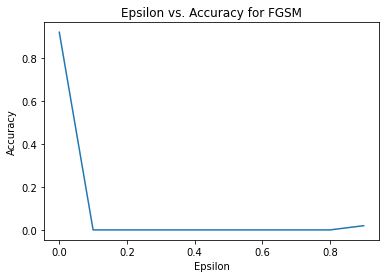

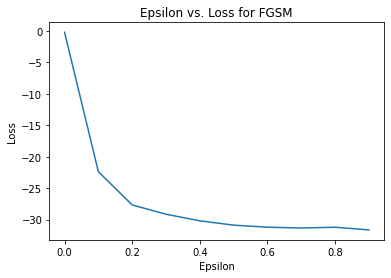

In [31]:
plt.plot(epsilon_range, accs)
plt.title("Epsilon vs. Accuracy for FGSM")
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.figure()
plt.plot(epsilon_range, [-i for i in losses])
plt.title("Epsilon vs. Loss for FGSM")
plt.xlabel('Epsilon')
plt.ylabel('Loss')

In [20]:
accs

[0.9215686274509803,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0196078431372549]

## Results for PMP and PGD

In [22]:
iteration_range = np.arange(0, 50, 2)
losses = []
loss_func = nn.CrossEntropyLoss()
adv_attack = GradientAttack(loss_func, 0.1) 

for iteration in iteration_range:
  loss_val = 0
  for data in test_dataloader:
    torch.cuda.empty_cache()   
    input = data['x'][0].to(dev)
    label = torch.tensor(data['y']).unsqueeze(0).to(dev)
    input = adv_attack.forward(input, label, model, num_iter=iteration)
    model.eval()
    out = model.lstm_block(input)
    loss_val += loss_func(out[0].unsqueeze(0), label.squeeze().unsqueeze(0).long()).item()
    
  losses.append(loss_val / len(test_dataloader))
  print(loss_val / len(test_dataloader))

with open("/content/gdrive/MyDrive/pgd_loss_vs_iter.txt", "wb") as fp:   #Pickling
  pickle.dump(losses, fp) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


0.22282284308868625
8.599254495957318
17.53493645611931
24.666958640603458
30.489852493884516
35.36489602631214
39.533982594807945
42.9270294787837
45.518556482651654
47.52478154500326
48.955764658310834
50.01097331327551
50.794347501268575
51.409664004456765
51.88273740282246
52.27823152729109
52.56445275101007
52.88704486921722
53.169510860069124
53.389765496347465
53.623431411443974
53.870964499080884
54.10911133710076
54.325781803505095
54.552167929855045


In [ ]:
'''iteration_range = np.arange(0, 50, 2)
losses = []
loss_func = nn.CrossEntropyLoss()
adv_attack = HAttack(loss, 0.1) 
for iteration in iteration_range:
  loss_val = 0
  for data in test_dataloader:
    torch.cuda.empty_cache()   
    input = data['x'][0].to(dev)
    label = torch.tensor(data['y']).unsqueeze(0).to(dev)
    input = adv_attack.forward(input, label, model, num_iter=iteration, pmp_iter=1)
    
    model.eval()
    out = model.lstm_block(input)
    loss_val += loss_func(out[0].unsqueeze(0), label.squeeze().unsqueeze(0).long()).item()
    
  losses.append(loss_val / len(test_dataloader))
  print(loss_val / len(test_dataloader))
with open("pgd_loss_vs_iter.txt", "wb") as fp:   #Pickling
  pickle.dump(losses, fp)'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()


0.2559793517130482
3.504762891241733
8.848793219117557
13.439042119418874
17.587407916199925


In [43]:
test_dataloader_saved = []

TypeError: ignored

In [ ]:
iteration_range = np.arange(0, 50, 2)
pmp_iteration_range = np.arange(1, 6, 1)
loss_func = nn.CrossEntropyLoss()
adv_attack2 = HAttack(loss_func, 0.1)

with open("/content/gdrive/MyDrive/pgd_loss_vs_iter.txt", "rb") as fp:   # Unpickling
  pgd_losses = pickle.load(fp)

for pmp_it in pmp_iteration_range:
    losses = []
    times = []
    test_dataloader_saved = []
    for iteration in iteration_range:
        loss_val = 0
        total_time = 0
        print(iteration)
        if iteration == 0:
          for data in test_dataloader:
              torch.cuda.empty_cache()   
              input = data['x'][0].to(dev)
              label = torch.tensor(data['y']).unsqueeze(0).to(dev)
              start = time.time()
              input = adv_attack2.forward(input, label, model, num_iter=0, pmp_iter=pmp_it, cnn=True)
              end = time.time()
              test_dataloader_saved.append((input.detach().cpu(), label.detach().cpu()))
              model.eval()
              out = model.lstm_block(input)
              loss_val += loss_func(out[0].unsqueeze(0), label.squeeze().unsqueeze(0).long()).item()
              total_time += end - start
        else:
          i = 0
          for data in test_dataloader_saved:
              torch.cuda.empty_cache()   
              input = data[0].to(dev)
              label = data[1].to(dev)
              start = time.time()
              input = adv_attack2.forward(input, label, model, num_iter=2, pmp_iter=pmp_it)
              end = time.time()
              test_dataloader_saved[i] = (input.detach().cpu(), label.detach().cpu())
              model.eval()
              out = model.lstm_block(input)
              loss_val += loss_func(out[0].unsqueeze(0), label.squeeze().unsqueeze(0).long()).item()
              total_time += end - start
              i += 1
        print(loss_val / len(test_dataloader))
        losses.append(loss_val / len(test_dataloader))
        times.append(total_time / len(test_dataloader))
    plt.figure(figsize=(10,10))
    plt.plot(iteration_range, [-i for i in pgd_losses], 'r-', label='PGD')
    plt.plot(iteration_range, [-i for i in losses], 'b--', label='PMP-' + str(pmp_it))
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Iteration vs. Loss, Epsilon = .1")
    with open("/content/gdrive/MyDrive/pmp" + str(pmp_it) + "_loss_vs_iter.txt", "wb") as fp:   #Pickling
      pickle.dump(losses, fp)
    with open("/content/gdrive/MyDrive/pmp" + str(pmp_it) + "_loss_vs_itertimes.txt", "wb") as fp:   #Pickling
      pickle.dump(times, fp)


0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


0.22282284308868625
2
8.73830693843318
4
18.434328658908022
6
26.907413707059973
8
34.61719535378849
10
41.24981364081888
12
46.825750874538045
14
51.673478930604226
16


In [39]:
losses

[0.22282284308868625,
 8.599256083077075,
 17.534938045576506,
 24.666958304012525,
 30.489853653253295,
 35.36491513719746]